In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean as cm
from matplotlib import colors
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings('ignore')
from dask.distributed import Client
import dask
import os

client =Client()



def format_3daxis(ax,lims):
    ax.patch.set_alpha(0)
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.zaxis.set_major_locator(plt.MaxNLocator(3))
    
    xmin,xmax,ymin,ymax,zmin, zmax = lims
    
    ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

    # Plot edges
    edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)

    #ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
    #ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
    #ax.plot([xmin, xmin], [ymin, ymax], 0, **edges_kw)
    #ax.plot([xmin, xmax], [ymax, ymax], 0, **edges_kw)
    
    ax.plot([xmax, xmax], [0, ymax], 5, **edges_kw)
    ax.plot([xmin, xmax], [0, 0], 5, **edges_kw)
    ax.plot([xmin, xmin], [0, ymax], 5, **edges_kw)
    ax.plot([xmin, xmax], [ymax, ymax], 5, **edges_kw)
    ax.plot([xmax, xmax], [0, 0], [zmin, zmax], **edges_kw)
    ax.plot([xmin, xmin], [0, 0], [zmin, zmax], **edges_kw)
    ax.plot([xmin, xmax], [0, 0], [zmin, zmin], **edges_kw)

    # Set labels and zticks
    ax.set(
        xlabel='X [km]',
        ylabel='Y [km]',
        zlabel='Depth [m]',
#         zticks=[0, -50, -100, -150],
    )

    # Set zoom and angle view
    ax.view_init(40, -60)
    ax.set_box_aspect((1,1,0.6), zoom=0.9)
    
def contour_rasterize(contour):
    for pathcoll in contour.collections:
        pathcoll.set_rasterized(True)

def axis_to_fig(axis):
    fig = axis.figure
    def transform(coord):
        return fig.transFigure.inverted().transform(
            axis.transAxes.transform(coord))
    return transform

def add_sub_axes(axis, rect,**kwargs):
    fig = axis.figure
    left, bottom, width, height = rect
    trans = axis_to_fig(axis)
    figleft, figbottom = trans((left, bottom))
    figwidth, figheight = trans([width,height]) - trans([0,0])
    return fig.add_axes([figleft, figbottom, figwidth, figheight],**kwargs)

def myfmt(x, pos):
    return '{0:.2f}'.format(x)


def remove_empty_ds(ds):
    filename = (ds.encoding['source'])
    print(ds.time)
    if len(ds.time)==0:
        print(filename)
    return ds


def load_format_data(path, var, isel, transpose=["yF","xF","zC"]):
    data = xr.open_mfdataset(file_paths)
    var = data[var].isel(isel).transpose(*transpose)
    return var

def format_data(data, var, isel,transpose=["yF","xF","zC"]):
    var = data[var].isel(isel).transpose(*transpose)
    return var

def plot3D(ax, X, Y, Z, var, kw):
    
    # Plot contour surfaces
    
    
    #half domain
    icut=int(var.shape[0]/2.)
    
    _t = ax.contourf(
        X[icut:, :, -1], Y[icut:, :, -1], var[icut:, :, -1].values,
        zdir='z', offset=0, **kw 
    )
    
    
    _r = ax.contourf(
        X[icut, :, :], var[icut, :, :].values, Z[icut, :, :],
        zdir='y', offset=0, **kw
    )
    
    C = ax.contourf(
        var[icut:, -1, :].values, Y[icut:, -1, :], Z[icut:, -1, :],
        zdir='x', offset=X.max(), **kw
    )
    
    #the full box:
    
    #_t = ax.contourf(
    #    X[:, :, -1], Y[:, :, -1], var[:, :, -1].values,
    #    zdir='z', offset=0, **kw 
    #)
    
    #_r = ax.contourf(
    #    X[0, :, :], var[0, :, :].values, Z[0, :, :],
    #    zdir='y', offset=Y.min(), **kw
    #)
    #C = ax.contourf(
    #    var[:, -1, :].values, Y[:, -1, :], Z[:, -1, :],
    #    zdir='x', offset=X.max(), **kw
    #)


   
    # Set limits of the plot from coord limits
    xmin, xmax = X.min(), X.max()
    ymin, ymax = Y.min(), Y.max()
    zmin, zmax = Z.min(), Z.max()
    
    lims = (xmin, xmax, ymin, ymax, zmin, zmax) 
    format_3daxis(ax,lims)
    
    return _t


def coriolis_frequency(latitude_degrees):
    import math
    omega = 7.2921e-5  # Earth's angular velocity (rad/s)
    phi_rad = math.radians(latitude_degrees)
    f0 = 2 * omega * math.sin(phi_rad)
    return f0

In [3]:

data_path = "/data/hpcflash/users/josnez/Oceananigans/ICE-EDDY_wJ/V0/RUN/AC-0"

lat=80
f0=coriolis_frequency(lat);print(f0)

vel_fields = "vel_fields*.nc"
tracer_fields = "tracer_fields*.nc"
vel_fields_paths = '{0}/{1}'.format(data_path, vel_fields)
tracer_fields_paths = '{0}/{1}'.format(data_path, tracer_fields)

data = xr.open_mfdataset(vel_fields_paths)# preprocess=remove_empty_ds )

0.00014362633231480645


Warning 3: Cannot find gdalvrt.xsd (GDAL_DATA is not defined)


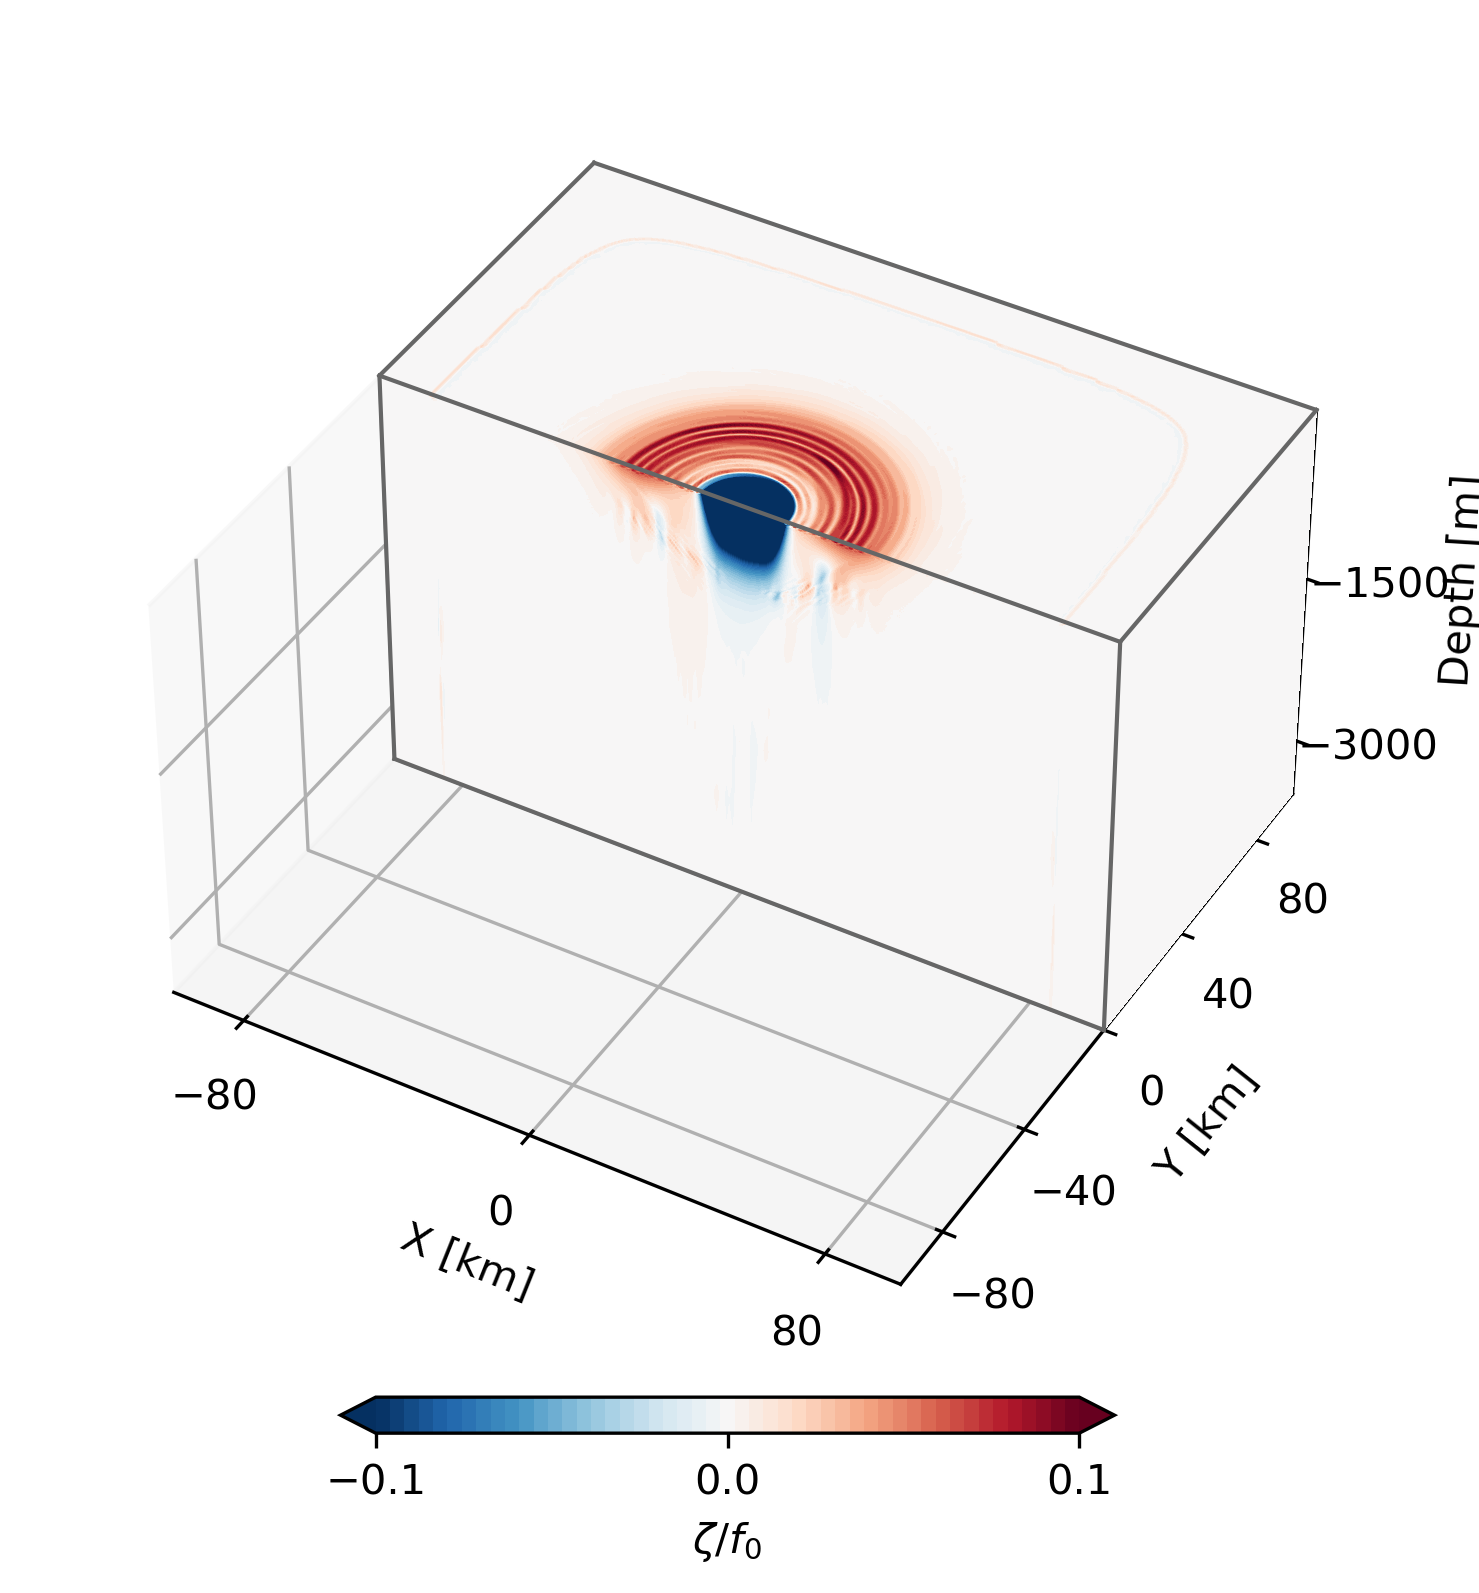

In [4]:
vmax=0.1
vmin=-vmax

kw = {
    'vmin': vmin,
    'vmax': vmax,
    'levels': np.linspace(vmin,vmax,50),
    'cmap': 'RdBu_r',
    'extend':'both'
}


var = data.vort.isel(time=150).transpose("yF","xF","zC")

Ny, Nx, Nz = var.shape

X = np.ones((Ny,Nx,Nz)) * var.xF.values[np.newaxis,:,np.newaxis] / 1000
Y = np.ones((Ny,Nx,Nz)) * var.yF.values[:, np.newaxis,np.newaxis] / 1000
Z = np.ones((Ny,Nx,Nz)) * var.zC.values[np.newaxis,np.newaxis,:]


# Create a figure with 3D ax
fig = plt.figure(figsize=(6, 6),dpi=300)
gs = GridSpec(1, 1, figure=fig)
########################################################################
ax1 = fig.add_subplot(gs[0, 0], projection='3d', computed_zorder=False)
cbar = plot3D(ax1, X, Y, Z, var/f0, kw)
plt.subplots_adjust(hspace=0.25, wspace=-0.35)
cax = fig.add_axes([0.3, 0.1, 0.43, 0.02])
cb=fig.colorbar(cbar, cax=cax, orientation='horizontal',label='$\zeta/f_0$',ticks=[-0.1,0,0.1])
cb.ax.locator_params(nbins=3)
plt.show()

In [ ]:
# Create a figure with 3D ax
fig = plt.figure(figsize=(12, 12),dpi=300)

kw = {
    'vmin': -1e-5,
    'vmax': 1e-5,
    'levels': np.arange(-1e-5,1e-5,1e-6),
    'cmap': cm.cm.delta,
    'extend':'both'
}

for time in range(0,len(data.time)):
    print(time, end='\r')
    gs = GridSpec(1, 1, figure=fig)

    ########################################################################
    ax1 = fig.add_subplot(gs[0, 0], projection='3d')

    ax = [ax1]
    ########################################################################
    
    isel = dict(time=time)

#     ax1.text2D(0.5, 1, 'Anticyclonic', horizontalalignment='center', verticalalignment='center', transform = ax1.transAxes,fontsize=14)
#     ax4.text2D(0.5, 1, 'Cyclonic', horizontalalignment='center', verticalalignment='center', transform = ax4.transAxes,fontsize=14)

    exp_name = r"Anticyclonic"

    var = format_data(data, "vort", isel)

    cbar = plot3D(ax[0], X, Y, Z, var, kw)

    ax[0].set_title(exp_name,y=0.98)


    cax = fig.add_axes([0.3, 0.1, 0.43, 0.02])
    cb=fig.colorbar(cbar, cax=cax, orientation='horizontal',label='$\zeta$')
    cb.ax.locator_params(nbins=3)

    # break 

    plt.subplots_adjust(hspace=0, wspace=-0.35)
    plt.savefig('./figures/animation/vorticity_Eddy_simulations_{0:03}.png'.format(time), dpi=300, bbox_inches='tight')
    plt.clf()

## Salinity

In [ ]:
data = xr.open_mfdataset(tracer_fields_paths)# preprocess=remove_empty_ds )

In [ ]:
var = data.S.isel(time=-1).transpose("yC","xC","zC")
var.min().compute(),var.max().compute()

In [ ]:
Ny, Nx, Nz = var.shape

X = np.ones((Ny,Nx,Nz)) * var.xC.values[np.newaxis,:,np.newaxis] / 1000
Y = np.ones((Ny,Nx,Nz)) * var.yC.values[:, np.newaxis,np.newaxis] / 1000
Z = np.ones((Ny,Nx,Nz)) * var.zC.values[np.newaxis,np.newaxis,:]

In [ ]:
# Create a figure with 3D ax
fig = plt.figure(figsize=(6, 6),dpi=300)


gs = GridSpec(1, 1, figure=fig)

########################################################################
ax1 = fig.add_subplot(gs[0, 0], projection='3d', computed_zorder=False)


kw = {
    'vmin': 31.5,
    'vmax': 35,
    'levels': np.arange(31.5,35,0.05),
    'cmap': cm.cm.haline,
    'extend':'both'
}

cbar = plot3D(ax1, X/1000, Y/1000, Z, var, kw)

plt.subplots_adjust(hspace=0.25, wspace=-0.35)


cax = fig.add_axes([0.3, 0.1, 0.43, 0.02])
cb=fig.colorbar(cbar, cax=cax, orientation='horizontal',label='$psu$')
cb.ax.locator_params(nbins=5)

In [ ]:
# Create a figure with 3D ax
fig = plt.figure(figsize=(12, 12),dpi=300)

kw = {
    'vmin': 31.5,
    'vmax': 35,
    'levels': np.arange(31.5,35,0.05),
    'cmap': cm.cm.haline,
    'extend':'both'
}

for time in range(0,len(data.time)):
    print(time, end='\r')
    gs = GridSpec(1, 1, figure=fig)

    ########################################################################
    ax1 = fig.add_subplot(gs[0, 0], projection='3d')

    ax = [ax1]
    ########################################################################
    
    isel = dict(time=time)

#     ax1.text2D(0.5, 1, 'Anticyclonic', horizontalalignment='center', verticalalignment='center', transform = ax1.transAxes,fontsize=14)
#     ax4.text2D(0.5, 1, 'Cyclonic', horizontalalignment='center', verticalalignment='center', transform = ax4.transAxes,fontsize=14)

    exp_name = r"$\psi$ = 5"

    var = format_data(data, "S", isel,transpose=["yC","xC","zC"])
    var = var
    
    cbar = plot3D(ax[0], X, Y, Z, var, kw)

    ax[0].set_title(exp_name,y=0.98)


    cax = fig.add_axes([0.3, 0.1, 0.43, 0.02])
    cb=fig.colorbar(cbar, cax=cax, orientation='horizontal',label='$psu$')
    cb.ax.locator_params(nbins=5)

    # break 

    plt.subplots_adjust(hspace=0, wspace=-0.35)
    plt.savefig('./figures/animation/salinity_Eddy_simulations_{0:03}.png'.format(time), dpi=300, bbox_inches='tight')
    plt.clf()

In [ ]:
!pwd